In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/DATA/my_data.zip'  # Adjust path if necessary
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [ ]:
!pip install tensorflow numpy Pillow


In [ ]:
# Import necessary libraries
import zipfile
import glob
from PIL import Image
import numpy as np
from tqdm import tqdm  # For progress bars



# Load and preprocess images
image_paths = sorted(glob.glob('/content/dataset/plans/*.png'))
images = []

# Convert images to grayscale, resize, and normalize
for img_path in tqdm(image_paths, desc="Loading and processing images"):
    img = Image.open(img_path).convert('L').resize((64, 64))  # Convert to grayscale
    images.append(np.array(img))

# Convert list to numpy array and normalize to [-1, 1] range
images = np.array(images) / 127.5 - 1.0  # Scale to [-1, 1]

# Load text descriptions
text_paths = sorted(glob.glob('/content/dataset/captions/*.txt'))

# Function to load text descriptions
def load_text_descriptions(text_paths):
    descriptions = []
    for path in text_paths:
        with open(path, 'r') as f:
            descriptions.append(f.read().strip())
    return descriptions


descriptions = load_text_descriptions(text_paths)

# Confirm loading
print(f"Loaded {len(images)} grayscale images and {len(descriptions)} descriptions.")

Loading and processing images: 100%|██████████| 1500/1500 [00:14<00:00, 105.00it/s]


Loaded 1500 grayscale images and 1500 descriptions.


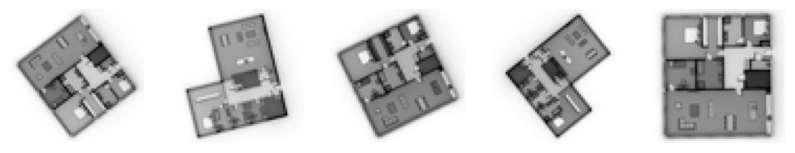

In [ ]:
import matplotlib.pyplot as plt

# Display a few sample images
num_samples = 5  # Number of images to display
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images[i], cmap='gray')  # Display in grayscale
    plt.axis('off')

plt.show()


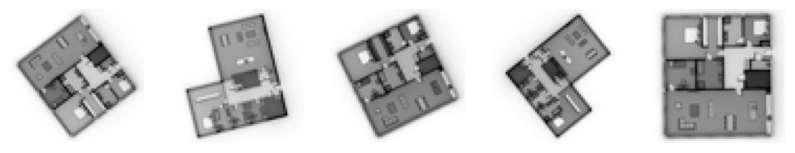

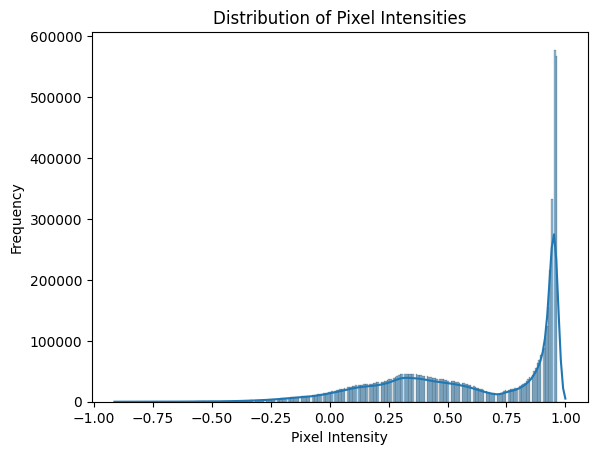

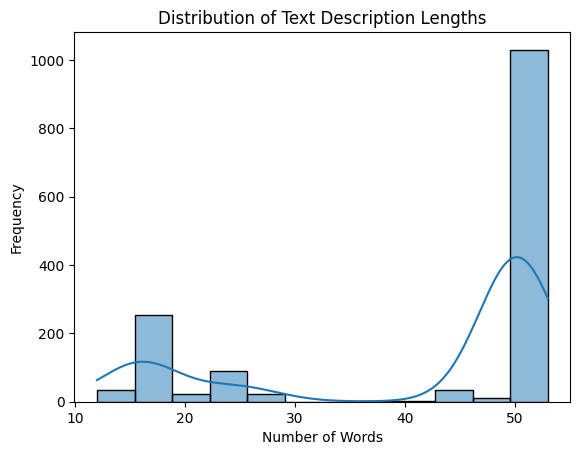

Most common words: [('the', 19290), ('bed,', 6212), ('wardrobe,', 6188), ('are', 2704), ('room,', 1637), ('and', 1530), ('rooms', 1510), ('a', 1500), ('floor', 1500), ('plan', 1500)]
Tokenized and padded descriptions (first 3): [[ 4  2  3  2  4  2  3  2  4  2  3  2  4  2  3  2  4  2  3  2]
 [ 4  2  3  2  4  2  3  2  4  2  3  2  4  2  3  2  4  2  3  2]
 [ 2 15  6 17 16  7 18  2 20 19  5  2 17 25  6 15  6 16  7 18]]
Final image data shape: (1500, 64, 64, 1)
Final text data shape: (1500, 20)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# EDA on Image Data
# Plot a few sample images to inspect visually
def plot_sample_images(images, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

plot_sample_images(images)

# Check image intensity distribution
pixel_values = np.concatenate([img.flatten() for img in images])
sns.histplot(pixel_values, kde=True)
plt.title("Distribution of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

# EDA on Text Data
# Check description length distribution
description_lengths = [len(desc.split()) for desc in descriptions]
sns.histplot(description_lengths, kde=True)
plt.title("Distribution of Text Description Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Common words in descriptions
all_words = ' '.join(descriptions).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(10)
print("Most common words:", common_words)

# Data Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Text Preprocessing for CGAN
max_words = 1000  # Adjust based on vocabulary size needs
max_len = 20      # Adjust based on average description length

# Tokenize and pad descriptions
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(descriptions)
sequences = tokenizer.texts_to_sequences(descriptions)
padded_descriptions = pad_sequences(sequences, maxlen=max_len, padding='post')

# Display tokenized and padded description for inspection
print("Tokenized and padded descriptions (first 3):", padded_descriptions[:3])

# Image Preprocessing: Ensure shape compatibility
images = images.reshape(-1, 64, 64, 1).astype('float32')  # Reshape and ensure float type

# Confirm final shapes and types
print("Final image data shape:", images.shape)
print("Final text data shape:", padded_descriptions.shape)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the Generator model
def make_generator(z_dim, text_embedding_dim):
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=z_dim + text_embedding_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1024),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(64 * 64, activation='tanh'),  # Output for grayscale images
        layers.Reshape((64, 64, 1))  # Grayscale channel
    ])
    return model

# Define the Discriminator model
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(64, 64, 1)),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Set latent dimension (z_dim) and text embedding dimension
z_dim = 100
text_embedding_dim = 768  # BERT text embeddings

# Instantiate models
generator = make_generator(z_dim, text_embedding_dim)
discriminator = make_discriminator()

# Compile models
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
!pip install transformers  # Make sure to install the transformers library if not already done

from transformers import BertTokenizer, TFBertModel

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to load text embeddings
def get_text_embedding(text, tokenizer, bert_model):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = bert_model(**inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1)

# Define the training loop for the CGAN
def train_cgan(generator, discriminator, epochs, batch_size, z_dim, images, descriptions, tokenizer, bert_model):
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0

        for i in tqdm(range(len(images) // batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
            # Generate random noise for the generator
            z = tf.random.normal([batch_size, z_dim])

            # Get text embeddings for the current batch
            text_embedding = get_text_embedding(descriptions[i * batch_size:(i + 1) * batch_size], tokenizer, bert_model)

            # Train the Generator
            with tf.GradientTape() as gen_tape:
                generated_images = generator(tf.concat([z, text_embedding], axis=1), training=True)
                fake_output = discriminator(generated_images, training=True)
                gen_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            # Train the Discriminator
            real_images = images[i * batch_size:(i + 1) * batch_size]
            real_images = np.expand_dims(real_images, axis=-1)  # Ensure grayscale shape compatibility
            real_labels = tf.ones_like(fake_output) * 0.9  # Label smoothing
            fake_labels = tf.zeros_like(fake_output)

            with tf.GradientTape() as disc_tape:
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)
                disc_loss_real = tf.keras.losses.binary_crossentropy(real_labels, real_output)
                disc_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels, fake_output)
                disc_loss = disc_loss_real + disc_loss_fake

            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            # Accumulate losses
            epoch_gen_loss += gen_loss.numpy().mean()
            epoch_disc_loss += disc_loss.numpy().mean()

        # Print loss for the epoch
        avg_gen_loss = epoch_gen_loss / (len(images) // batch_size)
        avg_disc_loss = epoch_disc_loss / (len(images) // batch_size)
        print(f"Epoch {epoch+1}/{epochs} - Generator loss: {avg_gen_loss:.4f}, Discriminator loss: {avg_disc_loss:.4f}")

# Set hyperparameters
epochs = 100
batch_size = 32

# Start training the CGAN
train_cgan(generator, discriminator, epochs, batch_size, z_dim, images, descriptions, tokenizer, bert_model)


Epoch 1/100: 100%|██████████| 46/46 [00:34<00:00,  1.34it/s]


Epoch 1/100 - Generator loss: 2.4319, Discriminator loss: 0.8133


Epoch 2/100: 100%|██████████| 46/46 [00:19<00:00,  2.37it/s]


Epoch 2/100 - Generator loss: 1.9296, Discriminator loss: 0.8700


Epoch 3/100: 100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 3/100 - Generator loss: 1.6223, Discriminator loss: 0.9553


Epoch 4/100: 100%|██████████| 46/46 [00:18<00:00,  2.55it/s]


Epoch 4/100 - Generator loss: 1.4801, Discriminator loss: 1.0077


Epoch 5/100: 100%|██████████| 46/46 [00:20<00:00,  2.27it/s]


Epoch 5/100 - Generator loss: 1.3548, Discriminator loss: 1.0439


Epoch 6/100: 100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 6/100 - Generator loss: 1.3459, Discriminator loss: 1.0455


Epoch 7/100: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 7/100 - Generator loss: 1.3402, Discriminator loss: 1.0847


Epoch 8/100: 100%|██████████| 46/46 [00:18<00:00,  2.49it/s]


Epoch 8/100 - Generator loss: 1.2297, Discriminator loss: 1.1098


Epoch 9/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 9/100 - Generator loss: 1.2278, Discriminator loss: 1.1374


Epoch 10/100: 100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 10/100 - Generator loss: 1.2174, Discriminator loss: 1.1970


Epoch 11/100: 100%|██████████| 46/46 [00:18<00:00,  2.49it/s]


Epoch 11/100 - Generator loss: 1.2450, Discriminator loss: 1.1636


Epoch 12/100: 100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Epoch 12/100 - Generator loss: 1.2218, Discriminator loss: 1.1413


Epoch 13/100: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 13/100 - Generator loss: 1.2067, Discriminator loss: 1.1726


Epoch 14/100: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 14/100 - Generator loss: 1.2197, Discriminator loss: 1.1486


Epoch 15/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 15/100 - Generator loss: 1.1595, Discriminator loss: 1.1400


Epoch 16/100: 100%|██████████| 46/46 [00:18<00:00,  2.51it/s]


Epoch 16/100 - Generator loss: 1.1436, Discriminator loss: 1.1919


Epoch 17/100: 100%|██████████| 46/46 [00:18<00:00,  2.51it/s]


Epoch 17/100 - Generator loss: 1.1465, Discriminator loss: 1.1831


Epoch 18/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 18/100 - Generator loss: 1.1461, Discriminator loss: 1.2202


Epoch 19/100: 100%|██████████| 46/46 [00:18<00:00,  2.51it/s]


Epoch 19/100 - Generator loss: 1.1313, Discriminator loss: 1.2484


Epoch 20/100: 100%|██████████| 46/46 [00:18<00:00,  2.54it/s]


Epoch 20/100 - Generator loss: 1.1110, Discriminator loss: 1.1973


Epoch 21/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 21/100 - Generator loss: 1.1593, Discriminator loss: 1.2516


Epoch 22/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 22/100 - Generator loss: 1.1320, Discriminator loss: 1.1813


Epoch 23/100: 100%|██████████| 46/46 [00:18<00:00,  2.49it/s]


Epoch 23/100 - Generator loss: 1.1851, Discriminator loss: 1.1922


Epoch 24/100: 100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 24/100 - Generator loss: 1.1206, Discriminator loss: 1.1882


Epoch 25/100: 100%|██████████| 46/46 [00:18<00:00,  2.43it/s]


Epoch 25/100 - Generator loss: 1.1160, Discriminator loss: 1.1724


Epoch 26/100: 100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 26/100 - Generator loss: 1.1333, Discriminator loss: 1.2194


Epoch 27/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 27/100 - Generator loss: 1.0858, Discriminator loss: 1.2222


Epoch 28/100: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 28/100 - Generator loss: 1.0950, Discriminator loss: 1.2147


Epoch 29/100: 100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 29/100 - Generator loss: 1.1147, Discriminator loss: 1.1865


Epoch 30/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 30/100 - Generator loss: 1.0941, Discriminator loss: 1.2036


Epoch 31/100: 100%|██████████| 46/46 [00:18<00:00,  2.48it/s]


Epoch 31/100 - Generator loss: 1.0796, Discriminator loss: 1.2325


Epoch 32/100: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 32/100 - Generator loss: 1.0833, Discriminator loss: 1.1867


Epoch 33/100: 100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 33/100 - Generator loss: 1.1117, Discriminator loss: 1.2151


Epoch 34/100: 100%|██████████| 46/46 [00:18<00:00,  2.49it/s]


Epoch 34/100 - Generator loss: 1.1384, Discriminator loss: 1.2099


Epoch 35/100: 100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 35/100 - Generator loss: 1.1093, Discriminator loss: 1.2232


Epoch 36/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 36/100 - Generator loss: 1.1424, Discriminator loss: 1.2518


Epoch 37/100: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 37/100 - Generator loss: 1.0993, Discriminator loss: 1.2129


Epoch 38/100: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 38/100 - Generator loss: 1.0754, Discriminator loss: 1.2093


Epoch 39/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 39/100 - Generator loss: 1.1140, Discriminator loss: 1.2012


Epoch 40/100: 100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 40/100 - Generator loss: 1.1312, Discriminator loss: 1.2296


Epoch 41/100: 100%|██████████| 46/46 [00:18<00:00,  2.51it/s]


Epoch 41/100 - Generator loss: 1.1039, Discriminator loss: 1.2476


Epoch 42/100: 100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Epoch 42/100 - Generator loss: 1.1254, Discriminator loss: 1.2112


Epoch 43/100: 100%|██████████| 46/46 [00:18<00:00,  2.55it/s]


Epoch 43/100 - Generator loss: 1.1192, Discriminator loss: 1.2189


Epoch 44/100: 100%|██████████| 46/46 [00:18<00:00,  2.50it/s]


Epoch 44/100 - Generator loss: 1.1107, Discriminator loss: 1.2508


Epoch 45/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 45/100 - Generator loss: 1.0505, Discriminator loss: 1.2379


Epoch 46/100: 100%|██████████| 46/46 [00:18<00:00,  2.55it/s]


Epoch 46/100 - Generator loss: 1.0736, Discriminator loss: 1.2653


Epoch 47/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 47/100 - Generator loss: 1.0238, Discriminator loss: 1.2504


Epoch 48/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 48/100 - Generator loss: 1.0887, Discriminator loss: 1.2343


Epoch 49/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 49/100 - Generator loss: 1.0270, Discriminator loss: 1.2739


Epoch 50/100: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 50/100 - Generator loss: 1.0461, Discriminator loss: 1.2418


Epoch 51/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 51/100 - Generator loss: 1.0601, Discriminator loss: 1.2461


Epoch 52/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 52/100 - Generator loss: 1.0548, Discriminator loss: 1.2574


Epoch 53/100: 100%|██████████| 46/46 [00:18<00:00,  2.45it/s]


Epoch 53/100 - Generator loss: 1.0520, Discriminator loss: 1.2542


Epoch 54/100: 100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Epoch 54/100 - Generator loss: 1.0639, Discriminator loss: 1.2381


Epoch 55/100: 100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Epoch 55/100 - Generator loss: 1.0382, Discriminator loss: 1.2473


Epoch 56/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 56/100 - Generator loss: 1.0404, Discriminator loss: 1.2859


Epoch 57/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 57/100 - Generator loss: 1.0073, Discriminator loss: 1.2559


Epoch 58/100: 100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Epoch 58/100 - Generator loss: 1.0773, Discriminator loss: 1.2202


Epoch 59/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 59/100 - Generator loss: 1.0940, Discriminator loss: 1.2361


Epoch 60/100: 100%|██████████| 46/46 [00:17<00:00,  2.63it/s]


Epoch 60/100 - Generator loss: 1.1003, Discriminator loss: 1.2602


Epoch 61/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 61/100 - Generator loss: 1.0649, Discriminator loss: 1.2214


Epoch 62/100: 100%|██████████| 46/46 [00:18<00:00,  2.42it/s]


Epoch 62/100 - Generator loss: 1.0717, Discriminator loss: 1.2324


Epoch 63/100: 100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Epoch 63/100 - Generator loss: 1.0093, Discriminator loss: 1.2538


Epoch 64/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 64/100 - Generator loss: 1.0049, Discriminator loss: 1.2674


Epoch 65/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 65/100 - Generator loss: 1.0220, Discriminator loss: 1.2320


Epoch 66/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 66/100 - Generator loss: 1.0734, Discriminator loss: 1.2804


Epoch 67/100: 100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Epoch 67/100 - Generator loss: 1.0486, Discriminator loss: 1.2756


Epoch 68/100: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 68/100 - Generator loss: 1.0670, Discriminator loss: 1.3118


Epoch 69/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 69/100 - Generator loss: 1.0201, Discriminator loss: 1.2384


Epoch 70/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 70/100 - Generator loss: 1.0289, Discriminator loss: 1.2459


Epoch 71/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 71/100 - Generator loss: 1.0313, Discriminator loss: 1.2466


Epoch 72/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 72/100 - Generator loss: 1.0518, Discriminator loss: 1.2504


Epoch 73/100: 100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Epoch 73/100 - Generator loss: 1.1017, Discriminator loss: 1.2410


Epoch 74/100: 100%|██████████| 46/46 [00:18<00:00,  2.45it/s]


Epoch 74/100 - Generator loss: 1.0402, Discriminator loss: 1.2309


Epoch 75/100: 100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Epoch 75/100 - Generator loss: 1.0453, Discriminator loss: 1.2448


Epoch 76/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 76/100 - Generator loss: 0.9813, Discriminator loss: 1.3020


Epoch 77/100: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 77/100 - Generator loss: 0.9866, Discriminator loss: 1.2956


Epoch 78/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 78/100 - Generator loss: 0.9810, Discriminator loss: 1.2875


Epoch 79/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 79/100 - Generator loss: 0.9822, Discriminator loss: 1.3246


Epoch 80/100: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 80/100 - Generator loss: 1.0175, Discriminator loss: 1.2619


Epoch 81/100: 100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Epoch 81/100 - Generator loss: 1.0155, Discriminator loss: 1.2788


Epoch 82/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 82/100 - Generator loss: 1.0605, Discriminator loss: 1.2623


Epoch 83/100: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 83/100 - Generator loss: 1.0041, Discriminator loss: 1.2736


Epoch 84/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 84/100 - Generator loss: 1.0081, Discriminator loss: 1.2797


Epoch 85/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 85/100 - Generator loss: 1.0277, Discriminator loss: 1.2403


Epoch 86/100: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 86/100 - Generator loss: 1.0403, Discriminator loss: 1.2650


Epoch 87/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 87/100 - Generator loss: 1.1097, Discriminator loss: 1.2377


Epoch 88/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 88/100 - Generator loss: 1.1139, Discriminator loss: 1.2366


Epoch 89/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 89/100 - Generator loss: 1.0678, Discriminator loss: 1.2364


Epoch 90/100: 100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 90/100 - Generator loss: 1.0527, Discriminator loss: 1.2499


Epoch 91/100: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 91/100 - Generator loss: 1.0342, Discriminator loss: 1.2411


Epoch 92/100: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 92/100 - Generator loss: 0.9904, Discriminator loss: 1.2586


Epoch 93/100: 100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 93/100 - Generator loss: 0.9988, Discriminator loss: 1.2645


Epoch 94/100: 100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Epoch 94/100 - Generator loss: 0.9888, Discriminator loss: 1.3205


Epoch 95/100: 100%|██████████| 46/46 [00:18<00:00,  2.51it/s]


Epoch 95/100 - Generator loss: 0.9446, Discriminator loss: 1.3548


Epoch 96/100: 100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 96/100 - Generator loss: 0.9420, Discriminator loss: 1.3072


Epoch 97/100: 100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 97/100 - Generator loss: 0.9904, Discriminator loss: 1.2813


Epoch 98/100: 100%|██████████| 46/46 [00:18<00:00,  2.50it/s]


Epoch 98/100 - Generator loss: 1.0100, Discriminator loss: 1.3182


Epoch 99/100: 100%|██████████| 46/46 [00:18<00:00,  2.54it/s]


Epoch 99/100 - Generator loss: 1.0427, Discriminator loss: 1.2748


Epoch 100/100: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]

Epoch 100/100 - Generator loss: 1.0542, Discriminator loss: 1.2448


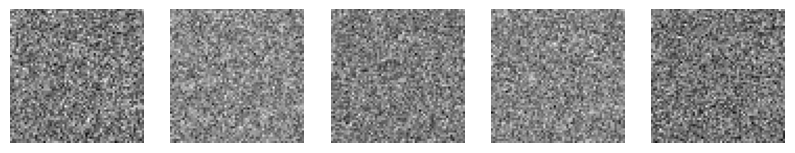

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to generate images from random noise (without text input)
def generate_images_without_text(generator, z_dim, num_images=5):
    z = tf.random.normal([num_images, z_dim])  # Random noise
    generated_images = generator(z, training=False)  # Generate images without text conditioning

    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0

    # Plot generated images
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and visualize images without text conditioning
generate_images_without_text(generator, z_dim)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


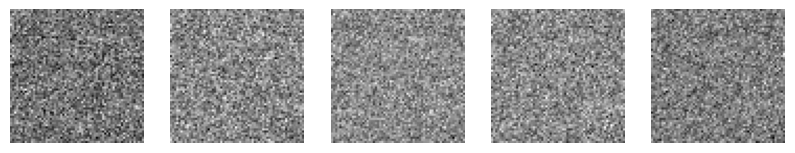

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Modified Generator model to handle both noise and text embeddings
def make_generator_model(z_dim, text_embedding_dim=None):
    model = tf.keras.Sequential()

    # If text embedding dimension is provided, use it
    if text_embedding_dim:
        model.add(layers.Dense(256, input_dim=z_dim + text_embedding_dim))  # Input combined z and text embedding
    else:
        model.add(layers.Dense(256, input_dim=z_dim))  # Input only z

    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1024))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(64 * 64, activation='tanh'))  # Output for grayscale images
    model.add(layers.Reshape((64, 64, 1)))  # Grayscale channel

    return model

# Function to generate images from random noise (without text input)
def generate_images_without_text(generator, z_dim, num_images=5):
    z = tf.random.normal([num_images, z_dim])  # Random noise
    generated_images = generator(z, training=False)  # Generate images without text conditioning

    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0

    # Plot generated images
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Example usage: Generate and visualize images without text conditioning
generator = make_generator_model(z_dim=100, text_embedding_dim=None)  # Assuming z_dim=100, no text input
generate_images_without_text(generator, z_dim=100)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Load the InceptionV3 model pretrained on ImageNet for FID and IS
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Helper function to preprocess images for Inception
def preprocess_images_for_inception(images):
    images = (images + 1) * 127.5  # Convert from [-1, 1] to [0, 255]
    images = tf.image.resize(images, (299, 299))

    # Convert grayscale to RGB (by duplicating the channel 3 times)
    if images.shape[-1] == 1:
        images = tf.repeat(images, 3, axis=-1)  # Repeat the grayscale channel 3 times to create RGB

    images = preprocess_input(images)
    return images

# Function to compute FID score
def calculate_fid(real_images, generated_images):
    # Preprocess real and generated images for Inception model
    real_images = preprocess_images_for_inception(real_images)
    generated_images = preprocess_images_for_inception(generated_images)

    # Calculate activations (features) for real and generated images
    real_features = inception_model.predict(real_images)
    generated_features = inception_model.predict(generated_images)

    # Calculate mean and covariance of the features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID score using the formula
    ssdiff = np.sum((mu_real - mu_generated)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_generated))

    # Check if covmean is complex due to numerical instability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = ssdiff + np.trace(sigma_real + sigma_generated - 2.0 * covmean)
    return fid_score

# Function to compute Inception Score (IS)
def calculate_inception_score(generated_images, n_splits=10):
    generated_images = preprocess_images_for_inception(generated_images)
    preds = inception_model.predict(generated_images)

    # Calculate Inception Score
    split_scores = []
    for i in range(n_splits):
        part = preds[i * (len(preds) // n_splits): (i + 1) * (len(preds) // n_splits)]
        py = np.mean(part, axis=0)
        split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))

    inception_score = np.mean(split_scores)
    return inception_score

# Example usage after training
# Assuming `images` is the array of real images and `generated_images` contains the generated images from your model

# Sample 100 real and generated images for faster computation
num_samples = 100
real_images_sample = images[:num_samples]
generated_images_sample = generator.predict(tf.random.normal([num_samples, z_dim]))

# Calculate FID and IS
fid_score = calculate_fid(real_images_sample, generated_images_sample)
inception_score = calculate_inception_score(generated_images_sample)

print("CGAN Evaluation Report")
print("=========================")
print(f"Frechet Inception Distance (FID): {fid_score}")
print(f"Inception Score (IS): {inception_score}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
CGAN Evaluation Report
Frechet Inception Distance (FID): 540.3552413729361
Inception Score (IS): nan


<ipython-input-18-c76f5f15fcdb>:56: RuntimeWarning: invalid value encountered in divide
  split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))
<ipython-input-18-c76f5f15fcdb>:56: RuntimeWarning: divide by zero encountered in log
  split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))
<ipython-input-18-c76f5f15fcdb>:56: RuntimeWarning: invalid value encountered in multiply
  split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy

# Load the InceptionV3 model pretrained on ImageNet for IS calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Helper function to preprocess images for Inception model
def preprocess_images_for_inception(images):
    # Rescale the images from [-1, 1] to [0, 255]
    images = (images + 1) * 127.5
    images = tf.image.resize(images, (299, 299))  # Resize to 299x299 as required by InceptionV3
    images = preprocess_input(images)  # Preprocess for InceptionV3
    return images

# Function to compute Inception Score (IS)
def calculate_inception_score(generated_images, n_splits=10):
    # Preprocess images for InceptionV3 model
    generated_images = preprocess_images_for_inception(generated_images)

    # Get the predictions for the images
    preds = inception_model.predict(generated_images)

    # Calculate Inception Score
    split_scores = []
    for i in range(n_splits):
        part = preds[i * (len(preds) // n_splits): (i + 1) * (len(preds) // n_splits)]
        # Calculate the KL divergence between the predicted class probabilities and their mean
        py = np.mean(part, axis=0)
        split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))  # KL Divergence

    inception_score = np.mean(split_scores)
    return inception_score

# Example usage:
# Assuming 'generated_images' is a batch of images generated by your model with shape (batch_size, 64, 64, 1)
# Rescale images to 3 channels (RGB) as InceptionV3 expects 3-channel images
generated_images_rgb = np.repeat(generated_images, 3, axis=-1)  # Convert grayscale to RGB by repeating the channels

# Calculate Inception Score
inception_score = calculate_inception_score(generated_images_rgb)

print(f"Inception Score (IS): {inception_score}")


NameError: name 'generated_images' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy

# Load the InceptionV3 model pretrained on ImageNet for IS calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Helper function to preprocess images for Inception model
def preprocess_images_for_inception(images):
    # Rescale the images from [-1, 1] to [0, 255]
    images = (images + 1) * 127.5
    images = tf.image.resize(images, (299, 299))  # Resize to 299x299 as required by InceptionV3
    images = preprocess_input(images)  # Preprocess for InceptionV3
    return images

# Function to compute Inception Score (IS)
def calculate_inception_score(generated_images, n_splits=10):
    # Preprocess images for InceptionV3 model
    generated_images = preprocess_images_for_inception(generated_images)

    # Get the predictions for the images
    preds = inception_model.predict(generated_images)

    # Calculate Inception Score
    split_scores = []
    for i in range(n_splits):
        part = preds[i * (len(preds) // n_splits): (i + 1) * (len(preds) // n_splits)]
        # Calculate the KL divergence between the predicted class probabilities and their mean
        py = np.mean(part, axis=0)
        split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))  # KL Divergence

    inception_score = np.mean(split_scores)
    return inception_score

# Assuming 'generated_images_sample' is a batch of images generated by your model
# Rescale images to 3 channels (RGB) as InceptionV3 expects 3-channel images
generated_images_rgb = np.repeat(generated_images_sample, 3, axis=-1)  # Convert grayscale to RGB by repeating the channels

# Calculate Inception Score
inception_score = calculate_inception_score(generated_images_rgb)

print(f"Inception Score (IS): {inception_score}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Inception Score (IS): nan


<ipython-input-20-b6761d5acef1>:31: RuntimeWarning: invalid value encountered in divide
  split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))  # KL Divergence
<ipython-input-20-b6761d5acef1>:31: RuntimeWarning: divide by zero encountered in log
  split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))  # KL Divergence
<ipython-input-20-b6761d5acef1>:31: RuntimeWarning: invalid value encountered in multiply
  split_scores.append(np.exp(np.mean(np.sum(part * np.log(part / py), axis=1))))  # KL Divergence


In [ ]:
from sklearn.metrics import jaccard_score
import numpy as np

def dice_similarity_coefficient(real_images, generated_images, threshold=0.5):
    # Binarize the images based on a threshold to detect structural similarity
    real_images_bin = (real_images > threshold).astype(np.float32)
    generated_images_bin = (generated_images > threshold).astype(np.float32)

    # Compute Dice coefficient for each pair of real and generated images
    intersection = np.sum(real_images_bin * generated_images_bin, axis=(1, 2, 3))
    sum_real = np.sum(real_images_bin, axis=(1, 2, 3))
    sum_generated = np.sum(generated_images_bin, axis=(1, 2, 3))

    dice_score = 2.0 * intersection / (sum_real + sum_generated)
    return dice_score.mean()

# Example usage (real_images and generated_images should be the same size)
dice_score = dice_similarity_coefficient(real_images_sample, generated_images_sample)
print(f"Dice Similarity Coefficient: {dice_score}")


Dice Similarity Coefficient: 1.619437534827739e-05


In [ ]:
def dice_similarity_coefficient(real_images, generated_images, thresholds=[0.3, 0.5, 0.7]):
    dice_scores = []
    for threshold in thresholds:
        real_images_bin = (real_images > threshold).astype(np.float32)
        generated_images_bin = (generated_images > threshold).astype(np.float32)
        intersection = np.sum(real_images_bin * generated_images_bin, axis=(1, 2, 3))
        sum_real = np.sum(real_images_bin, axis=(1, 2, 3))
        sum_generated = np.sum(generated_images_bin, axis=(1, 2, 3))
        dice_score = 2.0 * intersection / (sum_real + sum_generated)
        dice_scores.append(np.mean(dice_score))
    return dice_scores

dice_scores = dice_similarity_coefficient(real_images_sample, generated_images_sample)
print(f"Dice Similarity Coefficients for different thresholds: {dice_scores}")


Dice Similarity Coefficients for different thresholds: [0.011570137, 1.6194375e-05, 0.0]


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

# Function to calculate Precision and Recall for CGAN-generated images
def calculate_precision_recall(real_images, generated_images, threshold=0.5):
    # Convert images from [-1, 1] to [0, 1] for easier thresholding
    real_images_bin = (real_images + 1) / 2.0  # Rescale real images to [0, 1]
    generated_images_bin = (generated_images + 1) / 2.0  # Rescale generated images to [0, 1]

    # Apply thresholding (e.g., consider pixel as 1 if greater than threshold, else 0)
    real_images_bin = (real_images_bin > threshold).astype(np.uint8)
    generated_images_bin = (generated_images_bin > threshold).astype(np.uint8)

    # Flatten the images for easier comparison
    real_images_bin = real_images_bin.reshape(-1)
    generated_images_bin = generated_images_bin.reshape(-1)

    # Calculate Precision and Recall
    precision = precision_score(real_images_bin, generated_images_bin)
    recall = recall_score(real_images_bin, generated_images_bin)

    return precision, recall

# Example usage after generating images
# Assuming 'images' is the real image dataset and 'generated_images' are the images produced by your CGAN model
num_samples = 100
real_images_sample = images[:num_samples]
generated_images_sample = generator.predict(tf.random.normal([num_samples, z_dim]))  # Adjust based on your model

# Calculate Precision and Recall
precision, recall = calculate_precision_recall(real_images_sample, generated_images_sample)

print(f"Precision: {precision}")
print(f"Recall: {recall}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: 0.9455607117917123
Recall: 0.492287738768101
